# Covariate processing pipeline
This notebook presents the extraction and processing of covariates used in the statistical analysis, demonstrated on an example subject from the dHCP cohort. The covariates include post-menstrual age (PMA), preterm birth (PTB), mean diffusivity (MD), relative ventricle volume (RVV) and local volume change (LVC).

Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys
import json

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.tools import *
from utils.metrics import *
from utils.tbm import *
from utils.plots import *

## 1. Post-menstrual age and preterm birth
We defined PTB as the number of weeks between age at birth (i.e. gestational age -- GA at birth) and the 37 week prematurity threshold (PTB = 37 - GA).

In [2]:
# Set file path
subj_dir = os.path.join(base_dir, "data", "dHCP", "example_subject")
ages_path = os.path.join(subj_dir, "ages.json")

# Load ages
ages = json.load(open(ages_path))

# Display ages
print(f"PMA: {ages['PMA']:.2f} [weeks]")
print(f"PTB: {ages['PTB']:.2f} [weeks]")

PMA: 39.86 [weeks]
PTB: -2.57 [weeks]


## 2. Mean diffusivity

### 2.a. Extraction of brain MD
We used dHCP labels created on the T2w anatomical image to extract MD in tissues of interest.

**Acquisition information:** The acquisition of MD images was performed with a spatial resolution of $1.17 \times 1.17 \times 1.5$ mm$^3$.

In [3]:
# Set directories
md_dir = os.path.join(subj_dir, "MD")
tse_dir = os.path.join(subj_dir, "TSE")
deriv_dir = os.path.join(md_dir, "derivatives")

# Set file path
MD_path = os.path.join(md_dir, "MD.nii.gz") 
T2w_path = os.path.join(tse_dir, "T2w.nii.gz")
dof_path = os.path.join(deriv_dir, "MD_T2w.dof")
T2w_dhcp_labels9_path = os.path.join(tse_dir, "dhcp_labels9.nii.gz")
dhcp_labels9_path = os.path.join(deriv_dir, "dhcp_labels9.nii.gz")
MD_metrics_path = os.path.join(md_dir, "MD_metrics.json")

# Register MD to T2w volume
mirtk_register(
    input_img1_path=MD_path,
    input_img2_path=T2w_path,
    output_dof_path=dof_path,
)

# Apply transform on label
mirtk_transform_image(
    input_path=T2w_dhcp_labels9_path,
    input_target_path=MD_path,
    input_invdof_path=dof_path,
    output_path=dhcp_labels9_path,
    label=True,
)

# Extraction of MD metrics using labels
extract_dhcp_mean_diffusivity_metrics(
    input_mean_diffusivity_path=MD_path,
    input_dhcp_labels9_path=dhcp_labels9_path,
    output_md_metrics_path=MD_metrics_path,
)

# Load metrics
md_metrics = json.load(open(MD_metrics_path))

# Display MD metrics
print(f"Brain MD (excluding CSF and ventricles): {md_metrics['brain_MD']:.2f} [mm².ms⁻¹]")
print(f"dGM MD: {md_metrics['dGM_MD']:.2f} [mm².ms⁻¹]")
print(f"WM MD: {md_metrics['WM_MD']:.2f} [mm².ms⁻¹]")

Brain MD (excluding CSF and ventricles): 1.23 [mm².ms⁻¹]
dGM MD: 1.07 [mm².ms⁻¹]
WM MD: 1.33 [mm².ms⁻¹]


### 2.b. Registration of MD image to dHCP atlas (for use in and voxel-wise analysis)
MD image was rigidly aligned to T2w subject space using MIRTK and non-linearly transformed to the atlas space using FSL. We used the available dHCP diffeomorphisms computed from anatomical T2w images as warp.

In [4]:
# Set directory
atlas_dir = os.path.join(base_dir, "data", "dHCP", "atlas", "anat")

# Set file path
MD_in_T2w_path = os.path.join(deriv_dir, "MD_in_T2w.nii.gz")
atlas_path = os.path.join(atlas_dir, "week40_T2w.nii.gz")
warp_path = os.path.join(subj_dir, "xfm", "T2w_to_extdhcp40wk.nii.gz")
MD_in_atlas_path = os.path.join(md_dir, "MD_in_extdhcp40wk.nii.gz")
MD_in_atlas_res15mm_path = os.path.join(md_dir, "MD_in_extdhcp40wk_res15mm.nii.gz")

# Rigidly transform to subject T2w space
mirtk_transform_image(
    input_path=MD_path,
    output_path=MD_in_T2w_path,
    input_target_path=T2w_path,
    input_invdof_path=dof_path,
)

# Non-linearly warp to dHCP week 40 atlas
fsl_apply_warp(
    input_img_path=MD_in_T2w_path,
    input_target_path=atlas_path,
    input_warp_path=warp_path,
    output_img_path=MD_in_atlas_path,
)

# Resample to 1.5 mm for voxel-wise analysis
mirtk_resample_image(
    input_path=MD_in_atlas_path,
    output_path=MD_in_atlas_res15mm_path,
    size=[1.5, 1.5, 1.5],
    interp="Linear with padding",
)

## 3. Relative ventricle volume
RVV was defined using the available dHCP tissue segmentation as the ventricular volume divided by the intracranial volume.

In [5]:
# Set file path
volume_metrics_path = os.path.join(subj_dir, "volume_metrics.json")

# RVV extraction
extract_dhcp_volume_metrics(
    input_dhcp_labels9_path=T2w_dhcp_labels9_path,
    output_volume_metrics_path=volume_metrics_path,
)

# Load RVV
volume_metrics = json.load(open(volume_metrics_path))

# Display RVV
print(f"RVV: {volume_metrics['RVV']:.2f} %")

RVV: 1.20 %


## 4. Local volume change
We used a tensor-based morphometry (TBM) approach which calculates the logarithm of the Jacobian determinant of the diffeomorphisms from subject space to the week by week template space as an indicator of local volume change (LVC). The Jacobians were subsequently warped to the 40 week template and smoothed by an isotropic Gaussian filter with 3 voxels STD kernel.

In [6]:
# Set file path
lvc_dir = os.path.join(subj_dir, "LVC")
jac_in_atlas_path = os.path.join(lvc_dir, "LVC_in_extdhcp40wks.nii.gz")
jac_in_atlas_res15mm_path = os.path.join(lvc_dir, "LVC_in_extdhcp40wks_res15mm.nii.gz")

# Create Jacobian determinant using ANTs/ANTsPy
# create_jacobian_determinant(
#     input_fixed_path=atlas_path,
#     input_moving_path=T2w_path,
#     output_jac_path=jac_in_atlas_path,
#     sigma=3.0,
# )

# Resample to 1.5 mm for voxel-wise analysis
mirtk_resample_image(
    input_path=jac_in_atlas_path,
    output_path=jac_in_atlas_res15mm_path,
    size=[1.5, 1.5, 1.5],
    interp="Linear with padding",
)

## 5. Spatial covariates in atlas space (MD and LVC)

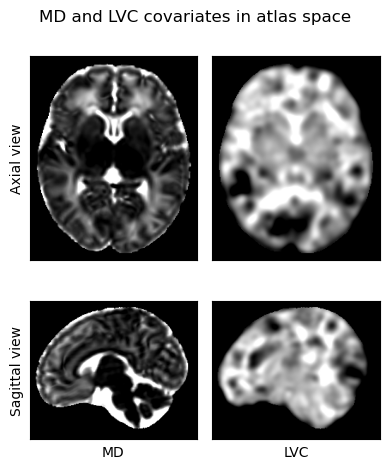

In [7]:
# Set file path
plot_path = os.path.join(base_dir, "plots", "processing_pipelines", "covariates_in_atlas.png")
mask_path = os.path.join(atlas_dir, "week40_mask.nii.gz")

# Plotting
covariates_plot(
    input_cov_paths=[MD_in_atlas_path, jac_in_atlas_path],
    input_cov_labels=["MD", "LVC"],
    input_mask_path=mask_path,
    output_plot_path=plot_path,
    view_info={"axial": { "slice_index": 98}, "sagittal": {"slice_index": 107}},
    figsize=(4, 5),
    title="MD and LVC covariates in atlas space",
    save_imageio=True,
)